## Poroelastic aquifer with ice sheet loading on half its domain

In [1]:
from matplotlib import rcParams
rcParams['font.family'] = 'Avenir'
rcParams['font.size'] = 14
import matplotlib.pyplot as plt
from matplotlib import cm

import numpy as np
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import inv
import time

np.set_printoptions(threshold=np.inf)

In [2]:
# Poroelastic properties
G = 10e9 # Shear modulus [GPa]
nu = 0.25 # Drained Poisson's ratio
nu_u = 0.35 # Undrained Poisson's ratio
alpha = 0.9 # Biot coefficient
rho_o = 1000 # Reference water density [kg/m^3]
g = 10 # gravitational acceleration
S = alpha**2*(1-2*nu_u)*(1-2*nu)/(2*G*(nu_u-nu)) # Specific storage coefficient at constant strain ($S_\varepsilon$)
k = 1e-12 # Aquifer permeability [m^2]
mu = 1e-3 # Dynamic viscosity of water [kg/(m·s)] 

# Model domain
L = 1000 # Width of domain [m]
H = 1000 # Height of domain [m]

# Numerical parameters:
dt = 1e3 # timestep [s]
nx = 32 # gridpoints in x-direction
ny = 24 # gridpoints in y-direction
nt = 5 # Number of timesteps to compute
dx = L/(nx-1) # Spacing of grid in x-direction
dy = H/(ny-1) # Spacing of grid in y-direction
[x2d,y2d]= np.meshgrid(np.arange(-L/2,L/2+dx,dx),np.arange(-H,0+dy,dy))
x = x2d[1,:]
y = y2d[:,1]

# Ice loads
sigma_ice = np.zeros([nx,1]) # Normal stress 
tau_ice = np.zeros([nx,1]) # Shear stress
sigma_ice[:nx//2] = -1e6
#tau_ice[:nx//2] = 1e6

# Setup arrays for variables to be solved for:
p = np.zeros([nx*ny,1]) # Change in pore pressure [Pa]
u = np.zeros([nx*ny,1]) # Horizontal displacements [m]
v = np.zeros([nx*ny,1]) # Vertical displacements [m]

Number = np.arange(0,nx*ny) 
Number = Number.reshape((nx,ny)) # Array of indices


In [3]:
# Construct time-independent A matrix:

A1_p = np.zeros((nx*ny,nx*ny)) #Pressure portion of fluid equations
A1_u = np.zeros((nx*ny,nx*ny)) #x-displacement portion of fluid equation
A1_v = np.zeros((nx*ny,nx*ny)) #y-displacement portion of fluid equation

A2_p = np.zeros((nx*ny,nx*ny)) #Pressure portion of first mechanical equation
A2_u = np.zeros((nx*ny,nx*ny)) #x-displacement portion of first mechanical equation
A2_v = np.zeros((nx*ny,nx*ny)) #y-displacement portion of first mechanical equation

A3_p = np.zeros((nx*ny,nx*ny)) #Pressure portion of second mechanical equation
A3_u = np.zeros((nx*ny,nx*ny)) #x-displacement portion of second mechanical equation
A3_v = np.zeros((nx*ny,nx*ny)) #y-displacement portion of second mechanical equation

sx = k/(alpha*mu*dx**2)
sy = k/(alpha*mu*dy**2)

for i in np.arange(0,nx): 
    for j in np.arange(0,ny):   
        
        # Fluid equation:
        A1_p[Number[i,j],Number[i,j]] = 2*sx+2*sy+S/(alpha*dt)

        if i == 0:
            A1_p[Number[i,j],Number[i+1,j]] = -2*sx
            A1_u[Number[i,j],Number[i+1,j]] = 1/(2*dx*dt)

        elif i == nx-1:
            A1_p[Number[i,j],Number[i-1,j]] = -2*sx
            A1_u[Number[i,j],Number[i-1,j]] = -1/(2*dx*dt)
            
        elif j == ny-1:
            if i <= nx/2:
                A1_p[Number[i,j],Number[i+1,j]] = -sx
                A1_p[Number[i,j],Number[i-1,j]] = -sx
                A1_u[Number[i,j],Number[i+1,j]] = (1-2*nu)/(1-nu)*1/(2*dx*dt)
                A1_u[Number[i,j],Number[i-1,j]] = -(1-2*nu)/(1-nu)*1/(2*dx*dt)
            else:
                A1_p[Number[i,j],Number[i,j]] = 1
            
        else:             
            A1_p[Number[i,j],Number[i+1,j]] = -sx
            A1_p[Number[i,j],Number[i-1,j]] = -sx
            A1_u[Number[i,j],Number[i+1,j]] = 1/(2*dx*dt)
            A1_u[Number[i,j],Number[i-1,j]] = -1/(2*dx*dt)
            
        if j == 0:    
            A1_p[Number[i,j],Number[i,j+1]] = -2*sy
            A1_v[Number[i,j],Number[i,j+1]] = 1/(2*dy*dt)

        elif j == ny-1:
            
            if i <= nx/2:
                A1_p[Number[i,j],Number[i,j-1]] = -2*sy
                A1_p[Number[i,j],Number[i,j]] = 2*sx+2*sy+S/(alpha*dt)+(1-2*nu)/(1-nu)*alpha/(2*G*dt)
            else:
                A1_p[Number[i,j],Number[i,j]] = 1
                
        else: 
            A1_p[Number[i,j],Number[i,j+1]] = -sy
            A1_p[Number[i,j],Number[i,j-1]] = -sy
            A1_v[Number[i,j],Number[i,j+1]] = 1/(2*dy*dt)
            A1_v[Number[i,j],Number[i,j-1]] = -1/(2*dy*dt)

        # Mechanical equation 1:
        if i == 0: 
            A2_u[Number[i,j],Number[i,j]] = 1
            
        elif i == nx-1:
            A2_u[Number[i,j],Number[i,j]] = 1
            
        elif j == 0: 
            A2_u[Number[i,j],Number[i,j]] = 1

        elif j == ny-1:
            A2_p[Number[i,j],Number[i+1,j]] = alpha/(2*dx*G)*(2*nu-1)/(2-2*nu)
            A2_p[Number[i,j],Number[i-1,j]] = -alpha/(2*dx*G)*(2*nu-1)/(2-2*nu)

            A2_u[Number[i,j],Number[i+1,j]] = (2-2*nu)/((1-2*nu)*dx**2)
            A2_u[Number[i,j],Number[i-1,j]] = (2-2*nu)/((1-2*nu)*dx**2)
            #A2_u[Number[i,j],Number[i,j+1]] = 1/(dy**2)
            A2_u[Number[i,j],Number[i,j-1]] = 2/(dy**2)
            A2_u[Number[i,j],Number[i,j]] = -2*(2-2*nu)/((1-2*nu)*dx**2)-2/(dy**2)+nu/((1-2*nu)*(1-nu)*2*dx**2)

            A2_v[Number[i,j],Number[i+1,j]] = -1/(dx*dy)
            A2_v[Number[i,j],Number[i-1,j]] = 1/(dx*dy)
            
            if i == 1:
                A2_u[Number[i,j],Number[i+2,j]] = -nu/((1-2*nu)*(1-nu)*4*dx**2)
            elif i == nx-2:
                A2_u[Number[i,j],Number[i-2,j]] = -nu/((1-2*nu)*(1-nu)*4*dx**2)
            else:
                A2_u[Number[i,j],Number[i+2,j]] = -nu/((1-2*nu)*(1-nu)*4*dx**2)
                A2_u[Number[i,j],Number[i-2,j]] = -nu/((1-2*nu)*(1-nu)*4*dx**2)
            
        else:        
            A2_p[Number[i,j],Number[i+1,j]] = -alpha/(2*dx*G)
            A2_p[Number[i,j],Number[i-1,j]] = alpha/(2*dx*G)

            A2_u[Number[i,j],Number[i+1,j]] = (2-2*nu)/((1-2*nu)*dx**2)
            A2_u[Number[i,j],Number[i-1,j]] = (2-2*nu)/((1-2*nu)*dx**2)
            A2_u[Number[i,j],Number[i,j+1]] = 1/(dy**2)
            A2_u[Number[i,j],Number[i,j-1]] = 1/(dy**2)
            A2_u[Number[i,j],Number[i,j]] = -2*(2-2*nu)/((1-2*nu)*dx**2)-2/(dy**2)

            A2_v[Number[i,j],Number[i+1,j+1]] = 1/((1-2*nu)*4*dx*dy)
            A2_v[Number[i,j],Number[i+1,j-1]] = -1/((1-2*nu)*4*dx*dy)
            A2_v[Number[i,j],Number[i-1,j+1]] = -1/((1-2*nu)*4*dx*dy)
            A2_v[Number[i,j],Number[i-1,j-1]] = 1/((1-2*nu)*4*dx*dy)   

        # Mechanical equation 2: 
        if i == 0 and j != 0 and j != ny-1:
            A3_p[Number[i,j],Number[i,j+1]] = -alpha/(2*dy*G)
            A3_p[Number[i,j],Number[i,j-1]] = alpha/(2*dy*G)

            A3_u[Number[i,j],Number[i+1,j+1]] = 1/((1-2*nu)*4*dx*dy)
            A3_u[Number[i,j],Number[i+1,j-1]] = -1/((1-2*nu)*4*dx*dy)
            #A3_u[Number[i,j],Number[i-1,j+1]] = -1/((1-2*nu)*4*dx*dy) # u_{i-1,j} = 0 at i == 0
            #A3_u[Number[i,j],Number[i-1,j-1]] = 1/((1-2*nu)*4*dx*dy)  # u_{i-1,j} = 0 at i == 0  

            A3_v[Number[i,j],Number[i,j+1]] = (2-2*nu)/((1-2*nu)*dy**2)
            A3_v[Number[i,j],Number[i,j-1]] = (2-2*nu)/((1-2*nu)*dy**2)
            A3_v[Number[i,j],Number[i+1,j]] = 2/(dx**2) # v_{i-1,j} = v_{i+1,j) at i == 0
            #A3_v[Number[i,j],Number[i-1,j]] = 1/(dx**2)
            A3_v[Number[i,j],Number[i,j]] = -2*(2-2*nu)/((1-2*nu)*dy**2)-2/(dx**2)
        
        elif i == nx-1:
            A3_v[Number[i,j],Number[i,j]] = 1

        elif j == 0:
            A3_v[Number[i,j],Number[i,j]] = 1
            
        elif j == ny-1:        

            if i == 0:
                A3_p[Number[i,j],Number[i,j]] = ((2-2*nu)/(1-nu))*alpha/(dy*G)

                A3_u[Number[i,j],Number[i+1,j]] = -2*nu/(1-2*nu)*(1/(dx*dy))
                #A3_u[Number[i,j],Number[i-1,j]] = 2*nu/(1-2*nu)*(1/(dx*dy)) #  u_{i-1,j} = 0 at the left boundary

                #A3_v[Number[i,j],Number[i,j+1]] = (2-2*nu)/((1-2*nu)*dy**2)
                A3_v[Number[i,j],Number[i,j-1]] = 2*(2-2*nu)/((1-2*nu)*dy**2)
                A3_v[Number[i,j],Number[i+1,j]] = 2/(dx**2) 
                #A3_v[Number[i,j],Number[i-1,j]] = 1/(dx**2) #v_{i-1,j} = v_{i+1,j} at the left boundary
                A3_v[Number[i,j],Number[i,j]] = -2*(2-2*nu)/((1-2*nu)*dy**2)-2/(dx**2)+1/((1-2*nu)*2*dx**2)-(1/(1-2*nu))*1/(4*dx**2) # Added last term because v_{i-2,j} = v_{i,j}
                A3_v[Number[i,j],Number[i+2,j]] = -(1/(1-2*nu))*1/(4*dx**2)
                #A3_v[Number[i,j],Number[i-2,j]] = -(1/(1-2*nu))*1/(4*dx**2) # zero gradient in vertical displacement BC: v_{i-2,j} = v_{i,j}
            
            elif i == 1:
                A3_p[Number[i,j],Number[i,j]] = ((2-2*nu)/(1-nu))*alpha/(dy*G)
                
                A3_u[Number[i,j],Number[i+1,j]] = -2*nu/(1-2*nu)*(1/(dx*dy))
                A3_u[Number[i,j],Number[i-1,j]] = 2*nu/(1-2*nu)*(1/(dx*dy))

                #A3_v[Number[i,j],Number[i,j+1]] = (2-2*nu)/((1-2*nu)*dy**2)
                A3_v[Number[i,j],Number[i,j-1]] = 2*(2-2*nu)/((1-2*nu)*dy**2)
                A3_v[Number[i,j],Number[i+1,j]] = 1/(dx**2)
                A3_v[Number[i,j],Number[i-1,j]] = 1/(dx**2)
                A3_v[Number[i,j],Number[i,j]] = -2*(2-2*nu)/((1-2*nu)*dy**2)-2/(dx**2)+1/((1-2*nu)*2*dx**2)-(1/(1-2*nu))*1/(4*dx**2) # Added last term because v_{i-2,j} = v_{i,j}
                A3_v[Number[i,j],Number[i+2,j]] = -(1/(1-2*nu))*1/(4*dx**2)
                #A3_v[Number[i,j],Number[i-2,j]] = -(1/(1-2*nu))*1/(4*dx**2) # zero gradient in vertical displacement BC: v_{i-2,j} = v_{i,j}
                
            elif i == nx-2:
                A3_p[Number[i,j],Number[i,j]] = ((2-2*nu)/(1-nu))*alpha/(dy*G)
                
                A3_u[Number[i,j],Number[i+1,j]] = -2*nu/(1-2*nu)*(1/(dx*dy))
                A3_u[Number[i,j],Number[i-1,j]] = 2*nu/(1-2*nu)*(1/(dx*dy))

                #A3_v[Number[i,j],Number[i,j+1]] = (2-2*nu)/((1-2*nu)*dy**2)
                A3_v[Number[i,j],Number[i,j-1]] = 2*(2-2*nu)/((1-2*nu)*dy**2)
                A3_v[Number[i,j],Number[i+1,j]] = 1/(dx**2)
                A3_v[Number[i,j],Number[i-1,j]] = 1/(dx**2)
                A3_v[Number[i,j],Number[i,j]] = -2*(2-2*nu)/((1-2*nu)*dy**2)-2/(dx**2)+1/((1-2*nu)*2*dx**2)
                #A3_v[Number[i,j],Number[i+2,j]] = -(1/(1-2*nu))*1/(4*dx**2) # v_{i+2,j} = 0 on the right boundary
                A3_v[Number[i,j],Number[i-2,j]] = -(1/(1-2*nu))*1/(4*dx**2)
                
            else: 
                A3_p[Number[i,j],Number[i,j]] = ((2-2*nu)/(1-nu))*alpha/(dy*G)
                
                A3_u[Number[i,j],Number[i+1,j]] = -2*nu/(1-2*nu)*(1/(dx*dy))
                A3_u[Number[i,j],Number[i-1,j]] = 2*nu/(1-2*nu)*(1/(dx*dy))

                #A3_v[Number[i,j],Number[i,j+1]] = (2-2*nu)/((1-2*nu)*dy**2)
                A3_v[Number[i,j],Number[i,j-1]] = 2*(2-2*nu)/((1-2*nu)*dy**2)
                A3_v[Number[i,j],Number[i+1,j]] = 1/(dx**2)
                A3_v[Number[i,j],Number[i-1,j]] = 1/(dx**2)
                A3_v[Number[i,j],Number[i,j]] = -2*(2-2*nu)/((1-2*nu)*dy**2)-2/(dx**2)+1/((1-2*nu)*2*dx**2)
                A3_v[Number[i,j],Number[i+2,j]] = -(1/(1-2*nu))*1/(4*dx**2)
                A3_v[Number[i,j],Number[i-2,j]] = -(1/(1-2*nu))*1/(4*dx**2)
                
        else:
            A3_p[Number[i,j],Number[i,j+1]] = -alpha/(2*dy*G)
            A3_p[Number[i,j],Number[i,j-1]] = alpha/(2*dy*G)

            A3_u[Number[i,j],Number[i+1,j+1]] = 1/((1-2*nu)*4*dx*dy)
            A3_u[Number[i,j],Number[i+1,j-1]] = -1/((1-2*nu)*4*dx*dy)
            A3_u[Number[i,j],Number[i-1,j+1]] = -1/((1-2*nu)*4*dx*dy)
            A3_u[Number[i,j],Number[i-1,j-1]] = 1/((1-2*nu)*4*dx*dy)    

            A3_v[Number[i,j],Number[i,j+1]] = (2-2*nu)/((1-2*nu)*dy**2)
            A3_v[Number[i,j],Number[i,j-1]] = (2-2*nu)/((1-2*nu)*dy**2)
            A3_v[Number[i,j],Number[i+1,j]] = 1/(dx**2)
            A3_v[Number[i,j],Number[i-1,j]] = 1/(dx**2)
            A3_v[Number[i,j],Number[i,j]] = -2*(2-2*nu)/((1-2*nu)*dy**2)-2/(dx**2)


A1 = np.concatenate((A1_p, A1_u, A1_v), axis=1)
A2 = np.concatenate((A2_p, A2_u, A2_v), axis=1)
A3 = np.concatenate((A3_p, A3_u, A3_v), axis=1)

A = np.concatenate((A1, A2, A3),axis=0)

# Compute inverse of time-independent matrix A: 

A_sparse = csr_matrix(A)
A_inv = inv(A_sparse) 

#print(A)

/Users/stacylarochelle/opt/anaconda3/lib/python3.9/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:347: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)
/Users/stacylarochelle/opt/anaconda3/lib/python3.9/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:239: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


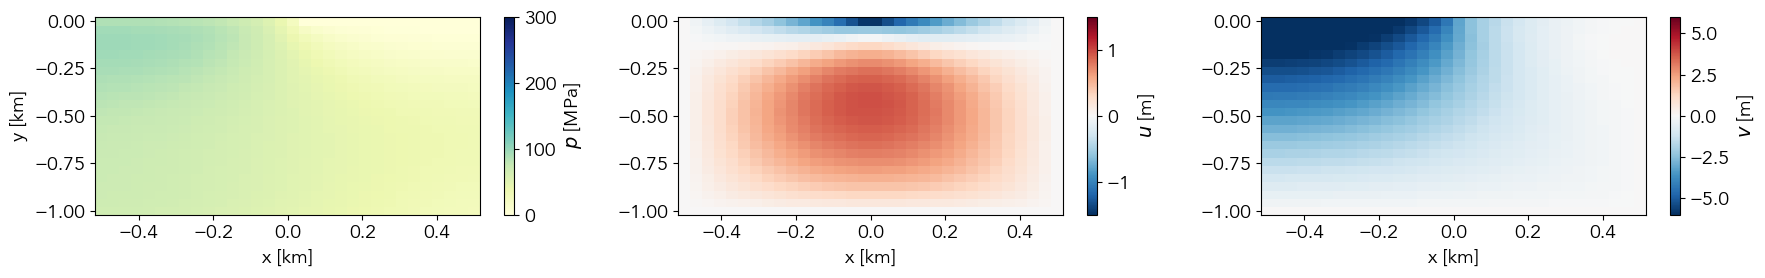

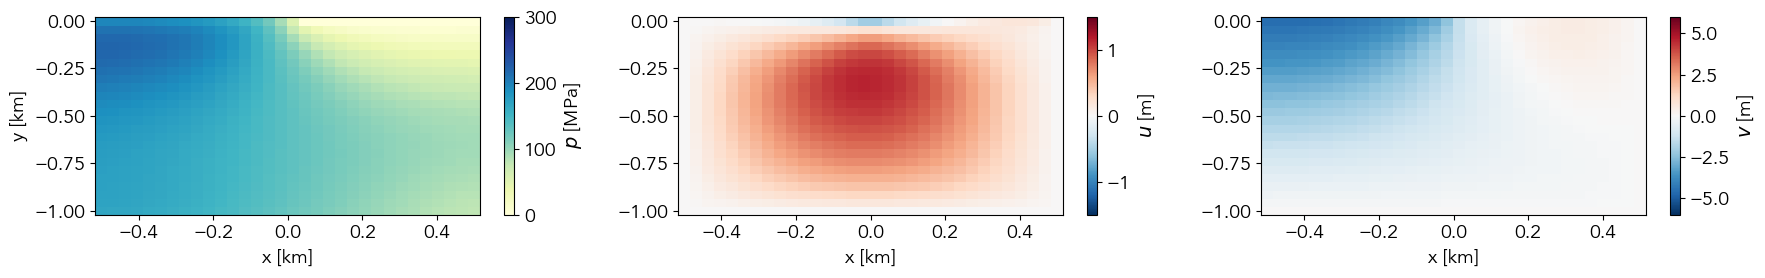

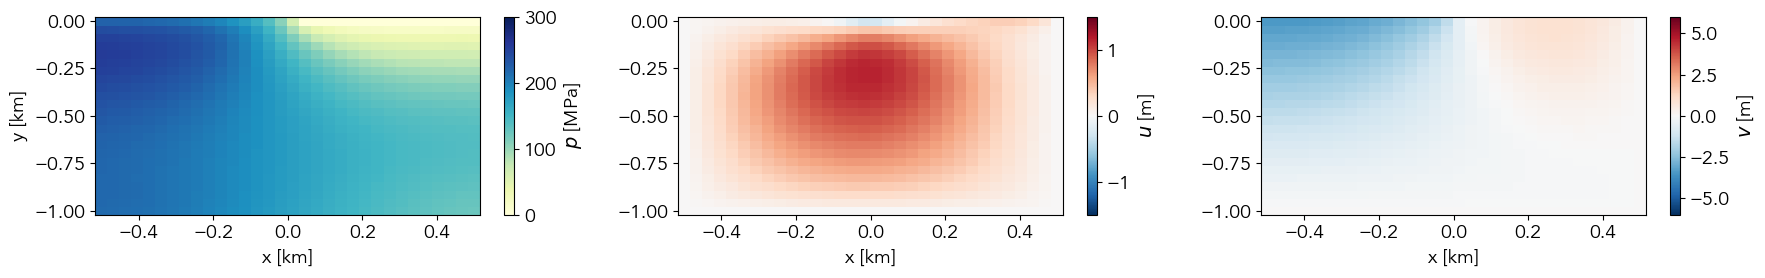

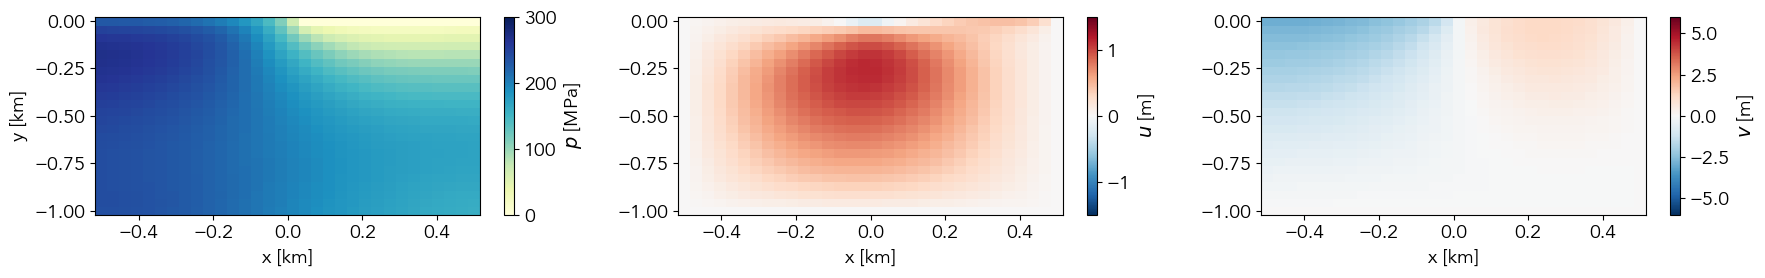

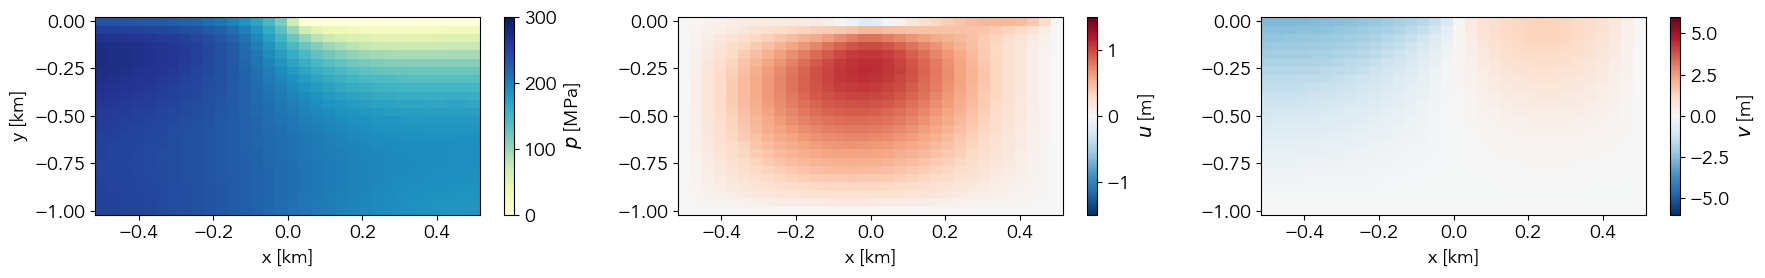

In [4]:
# Main time loop:

time = 0

for n in np.arange(0,nt):
    b1 = np.zeros([nx*ny,1]) # b vector for fluid equations
    b2 = np.zeros([nx*ny,1]) # b vector for first mechanical equation
    b3 = np.zeros([nx*ny,1]) # b vector for second mechanical equation
    
    for i in np.arange(0,nx): 
        for j in np.arange(0,ny):    
    
            b2[Number[i,j]] = 0
            b3[Number[i,j]] = 0
            
            if i == 0 and j != 0 and j != ny-1:
                b1[Number[i,j]] = -1/(2*dx*dt)*(u[Number[i+1,j]])-1/(2*dy*dt)*(v[Number[i,j+1]]-v[Number[i,j-1]])+S/(alpha*dt)*p[Number[i,j]]  # Set u_{i-1,j} = 0

            elif i == nx-1 and j != 0 and j != ny-1:
                b1[Number[i,j]] = -1/(2*dx*dt)*(-u[Number[i-1,j]])-1/(2*dy*dt)*(v[Number[i,j+1]]-v[Number[i,j-1]])+S/(alpha*dt)*p[Number[i,j]] # Set u_{i+1,j} = 0
                
            elif j == 0:
                if i == 0:
                    b1[Number[i,j]] = -1/(2*dx*dt)*(u[Number[i+1,j]])-1/(2*dy*dt)*(v[Number[i,j+1]])+S/(alpha*dt)*p[Number[i,j]] # Set v_{i,j-1} = 0 and u_{i-1,j} = 0
                elif i == nx-1:
                    b1[Number[i,j]] = -1/(2*dx*dt)*(-u[Number[i-1,j]])-1/(2*dy*dt)*(v[Number[i,j+1]])+S/(alpha*dt)*p[Number[i,j]] # Set v_{i,j-1} = 0 and u_{i+1,j} = 0
                else:    
                    b1[Number[i,j]] = -1/(2*dx*dt)*(u[Number[i+1,j]]-u[Number[i-1,j]])-1/(2*dy*dt)*(v[Number[i,j+1]])+S/(alpha*dt)*p[Number[i,j]] # Set v_{i,j-1} = 0           
            
            elif j == ny - 1:
                
                b2[Number[i,j]] = -2*tau_ice[i]/(dy*G)
                b3[Number[i,j]] = -(1-2*nu/(1-nu))*sigma_ice[i]*dy/G
                
                if i == 0:
                    b1[Number[i,j]] = -(1-2*nu)/(1-nu)*1/(2*dx*dt)*(u[Number[i+1,j]])+(S/(alpha*dt)-(1-2*nu)/(1-nu)*alpha/(dt*G))*p[Number[i,j]]-2/dt*(1-2*nu)/(1-nu)*sigma_ice[i]/G

                elif i > nx/2:    
                    b1[Number[i,j]] = 0
                # elif i == nx-1:
                #     b1[Number[i,j]] = -(1-2*nu)/(1-nu)*1/(2*dx*dt)*(-u[Number[i-1,j]])+(S/(alpha*dt)-(1-2*nu)/(1-nu)*alpha/(dt*G))*p[Number[i,j]]-2/dt*(1-2*nu)/(1-nu)*sigma_ice[i]/G

                else:
                    b1[Number[i,j]] = -(1-2*nu)/(1-nu)*1/(2*dx*dt)*(u[Number[i+1,j]]-u[Number[i-1,j]])+(S/(alpha*dt)-(1-2*nu)/(1-nu)*alpha/(dt*G))*p[Number[i,j]]-2/dt*(1-2*nu)/(1-nu)*sigma_ice[i]/G

            else:
                b1[Number[i,j]] = -1/(2*dx*dt)*(u[Number[i+1,j]]-u[Number[i-1,j]])-1/(2*dy*dt)*(v[Number[i,j+1]]-v[Number[i,j-1]])+S/(alpha*dt)*p[Number[i,j]]

    b = np.concatenate((b1, b2, b3),axis=0)
    
    x = A_inv*b
    
    # Update variables: 
    
    p = x[Number.flatten()]
    u = x[Number.flatten()+nx*ny]
    v = x[Number.flatten()+2*nx*ny]
        
    p = p.reshape((nx,ny))
    u = u.reshape((nx,ny))
    v = v.reshape((nx,ny))
        
    fig, ax = plt.subplots(1,3,figsize = (18,3))

    p1 = ax[0].pcolor(x2d/1e3,y2d/1e3,p.T/1e6,cmap='YlGnBu',shading = 'auto',vmin=0,vmax=300)
    ax[0].set_xlabel("x [km]")
    ax[0].set_ylabel("y [km]")
    #ax[0].set_title('Time = '+str(round(time/3600/24))+' days')
    cb = plt.colorbar(p1,ax=ax[0],aspect = 20)
    cb.set_label(label='$p$ [MPa]')
    #cb.ax.tick_params(labelsize=16)
    
    p2 = ax[1].pcolor(x2d/1e3,y2d/1e3,u.T,cmap='RdBu_r',shading = 'auto',vmin=-1.5,vmax=1.5)
    ax[1].set_xlabel("x [km]")
    #ax[1].set_ylabel("y [m]")
    #ax[0].set_title('Time = '+str(round(time/3600/24))+' days')
    cb = plt.colorbar(p2,ax=ax[1],aspect = 20)
    cb.set_label(label='$u$ [m]')
    #cb.ax.tick_params(labelsize=16)
    
    p3 = ax[2].pcolor(x2d/1e3,y2d/1e3,v.T,cmap='RdBu_r',shading = 'auto',vmin=-6,vmax=6)
    ax[2].set_xlabel("x [km]")
    #ax[2].set_ylabel("y [m]")
    #ax[0].set_title('Time = '+str(round(time/3600/24))+' days')
    cb = plt.colorbar(p3,ax=ax[2],aspect = 20)
    cb.set_label(label='$v$ [m]')
    #cb.ax.tick_params(labelsize=16)
    
    plt.tight_layout()
    
    p = p.flatten()
    u = u.flatten()
    v = v.flatten()
    
    time = time + dt
